# Task 4: Customer Satisfaction Analysis

This notebook performs an in-depth analysis of customer satisfaction based on engagement and experience scores. The steps include calculating engagement and experience scores, determining satisfaction scores, building a regression model, running k-means clustering, aggregating scores per cluster, and exporting results to a MySQL database.

## 1. Setup and Import Libraries

```python
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sqlalchemy import create_engine
import matplotlib.pyplot as plt


In [11]:
import psycopg2

class PostgresConnection:
    def __init__(self, dbname, user, password, host='localhost', port='5432'):
        self.dbname = dbname
        self.user = user
        self.password = password
        self.host = host
        self.port = port
        self.conn = None
        self.cursor = None

    def connect(self):
        try:
            self.conn = psycopg2.connect(
                dbname=self.dbname,
                user=self.user,
                password=self.password,
                host=self.host,
                port=self.port
            )
            self.cursor = self.conn.cursor()
            print("Connected to PostgreSQL database!")
        except Exception as e:
            print(f"Error: {e}")

    def execute_query(self, query):
        try:
            self.cursor.execute(query)
            rows = self.cursor.fetchall()
            return rows
        except Exception as e:
            print(f"Error executing query: {e}")
            return None

    def close_connection(self):
        if self.conn is not None:
            self.conn.close()
            print("Connection closed.")

    def fetch_to_dataframe(self, query):
        try:
            rows = self.execute_query(query)
            if rows:
                df = pd.DataFrame(rows, columns=[desc[0] for desc in self.cursor.description])
                return df
            else:
                return None
        except Exception as e:
            print(f"Error fetching data: {e}")
            return None

# Instantiate and connect to the database
db = PostgresConnection(dbname='my_database', user='postgres', password='123', host='localhost', port='5432')
db.connect()


Connected to PostgreSQL database!


In [12]:
# Fetch data
query = "SELECT * FROM public.xdr_data"  # Update with the actual table name
df = db.fetch_to_dataframe(query)

# Check the result
if df is not None:
    print(df.head())

    # Data cleaning and processing
    df.dropna(inplace=True)
    df.fillna(0, inplace=True)
else:
    print("Failed to retrieve data.")

db.close_connection()


      Bearer Id           Start  Start ms              End  End ms  Dur. (ms)  \
0  7.349883e+18  4/28/2019 3:12      77.0  4/29/2019 10:29   769.0   112615.0   
1  7.277826e+18  4/28/2019 3:12     776.0   4/29/2019 3:12   755.0    86399.0   
2  7.277826e+18  4/28/2019 3:12     819.0   4/29/2019 3:12   741.0    86399.0   
3  1.311448e+19  4/28/2019 3:12     967.0   4/29/2019 0:56   454.0    78214.0   
4  7.349883e+18  4/28/2019 3:12     496.0   4/29/2019 0:15   901.0    75753.0   

           IMSI  MSISDN/Number          IMEI Last Location Name  ...  \
0  2.082010e+14   3.366549e+10  3.553811e+13            L19259B  ...   
1  2.082017e+14   3.376161e+10  8.637690e+13            D77752A  ...   
2  2.082009e+14   3.365004e+10  8.637690e+13            T21361B  ...   
3  2.082009e+14   3.369554e+10  3.578101e+13            T86660C  ...   
4  2.082018e+14   3.366249e+10  3.561351e+13            D11247A  ...   

   Youtube DL (Bytes)  Youtube UL (Bytes)  Netflix DL (Bytes)  \
0           108

In [13]:
# Print the columns of the DataFrame
print(df.columns)


Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [14]:
engagement_col = 'Avg Bearer TP DL (kbps)'
experience_col = 'Avg Bearer TP UL (kbps)'


In [15]:
import pandas as pd
from scipy import stats

# Sample DataFrame loading (replace this with your actual data loading method)
# df = pd.read_csv('your_data_file.csv')

# Convert columns to numeric
df[engagement_col] = pd.to_numeric(df[engagement_col], errors='coerce')
df[experience_col] = pd.to_numeric(df[experience_col], errors='coerce')

# Drop rows with missing values in these columns
df.dropna(subset=[engagement_col, experience_col], inplace=True)


In [16]:
# Calculate Z-scores
z_scores = stats.zscore(df[[engagement_col, experience_col]])

# Convert Z-scores to DataFrame
z_scores_df = pd.DataFrame(z_scores, columns=[engagement_col, experience_col])

# Identify outliers
outliers = (abs(z_scores_df) > 3).all(axis=1)
df_outliers = df[outliers]

print("Outliers detected:")
print(df_outliers)


Outliers detected:
           Bearer Id            Start  Start ms             End  End ms  \
215     7.277826e+18   4/28/2019 3:21     360.0  4/29/2019 9:46   899.0   
829     7.277826e+18   4/28/2019 3:43     180.0  4/29/2019 3:43   140.0   
1430    7.277826e+18   4/28/2019 4:06     495.0  4/29/2019 4:06   503.0   
16336   7.277826e+18   4/29/2019 0:29     722.0  4/30/2019 0:29   671.0   
20170   1.304243e+19   4/29/2019 3:11     858.0  4/30/2019 3:11   189.0   
21760   7.277826e+18   4/29/2019 4:04     973.0  4/30/2019 4:04   993.0   
22197   1.304243e+19   4/29/2019 4:16     936.0  4/30/2019 4:16   938.0   
23613   1.304243e+19   4/29/2019 4:52     345.0  4/30/2019 4:53   393.0   
27351   1.304243e+19   4/29/2019 6:48     162.0  4/30/2019 6:48    95.0   
27829   7.277826e+18   4/29/2019 6:57     826.0  4/30/2019 6:57   764.0   
32146   1.304243e+19   4/24/2019 2:00     177.0  4/25/2019 2:00   143.0   
33379   1.304243e+19   4/24/2019 3:26     733.0  4/25/2019 3:26   609.0   
33435 

In [17]:
import pandas as pd
from scipy import stats

# Sample DataFrame loading (replace this with your actual data loading method)
# df = pd.read_csv('your_data_file.csv')

# Define relevant columns
engagement_col = 'Avg Bearer TP DL (kbps)'
experience_col = 'Avg Bearer TP UL (kbps)'

# Convert columns to numeric
df[engagement_col] = pd.to_numeric(df[engagement_col], errors='coerce')
df[experience_col] = pd.to_numeric(df[experience_col], errors='coerce')

# Drop rows with missing values in these columns
df.dropna(subset=[engagement_col, experience_col], inplace=True)

# Calculate Z-scores
z_scores = stats.zscore(df[[engagement_col, experience_col]])

# Convert Z-scores to DataFrame
z_scores_df = pd.DataFrame(z_scores, columns=[engagement_col, experience_col])

# Identify outliers
outliers = (abs(z_scores_df) > 3).all(axis=1)
df_outliers = df[outliers]

print("Outliers detected:")
print(df_outliers)


Outliers detected:
           Bearer Id            Start  Start ms             End  End ms  \
215     7.277826e+18   4/28/2019 3:21     360.0  4/29/2019 9:46   899.0   
829     7.277826e+18   4/28/2019 3:43     180.0  4/29/2019 3:43   140.0   
1430    7.277826e+18   4/28/2019 4:06     495.0  4/29/2019 4:06   503.0   
16336   7.277826e+18   4/29/2019 0:29     722.0  4/30/2019 0:29   671.0   
20170   1.304243e+19   4/29/2019 3:11     858.0  4/30/2019 3:11   189.0   
21760   7.277826e+18   4/29/2019 4:04     973.0  4/30/2019 4:04   993.0   
22197   1.304243e+19   4/29/2019 4:16     936.0  4/30/2019 4:16   938.0   
23613   1.304243e+19   4/29/2019 4:52     345.0  4/30/2019 4:53   393.0   
27351   1.304243e+19   4/29/2019 6:48     162.0  4/30/2019 6:48    95.0   
27829   7.277826e+18   4/29/2019 6:57     826.0  4/30/2019 6:57   764.0   
32146   1.304243e+19   4/24/2019 2:00     177.0  4/25/2019 2:00   143.0   
33379   1.304243e+19   4/24/2019 3:26     733.0  4/25/2019 3:26   609.0   
33435 

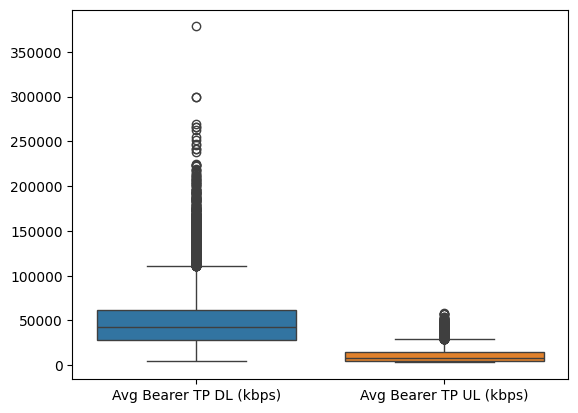

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot to visualize outliers
sns.boxplot(data=df[[engagement_col, experience_col]])
plt.show()


In [44]:
# Compute satisfaction score
df['satisfaction_score'] = (df[engagement_col] + df[experience_col]) / 2

# Find top 10 satisfied customers based on satisfaction score
top_10_satisfied = df.nlargest(10, 'satisfaction_score')
print("Top 10 satisfied customers:")
print(top_10_satisfied[['Bearer Id', 'satisfaction_score']])


Top 10 satisfied customers:
           Bearer Id  satisfaction_score
1192    1.304243e+19            191131.0
23972   7.277826e+18            156622.0
21564   7.277826e+18            152149.5
121616  7.277826e+18            150273.0
147110  7.277826e+18            141965.5
21760   7.277826e+18            140572.0
122496  7.277826e+18            138102.5
146868  7.277826e+18            137026.0
148094  1.304243e+19            134944.0
146153  1.304243e+19            134696.0


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define features and target variable
X = df[[engagement_col, experience_col]]
y = df['satisfaction_score']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Print model coefficients
print("Model coefficients:")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")


Mean Squared Error: 8.208596996546548e-22
Model coefficients:
Intercept: 4.729372449219227e-11
Coefficients: [0.5 0.5]


In [21]:
from sklearn.cluster import KMeans

# Prepare data for clustering
X_clustering = df[[engagement_col, experience_col]]

# Initialize KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
df['cluster'] = kmeans.fit_predict(X_clustering)

# Display cluster centers
print("Cluster centers:")
print(kmeans.cluster_centers_)

# Display cluster assignments
print(df[['Bearer Id', 'cluster']])


Cluster centers:
[[91091.31174289 14611.77132262]
 [36216.65596093 10023.0974617 ]]
           Bearer Id  cluster
2       7.277826e+18        1
9       1.304243e+19        1
21      1.304243e+19        1
23      1.304243e+19        0
27      7.277826e+18        1
...              ...      ...
149985  1.304243e+19        0
149987  1.304243e+19        1
149991  7.277826e+18        0
149993  1.304243e+19        1
149996  1.304243e+19        1

[17558 rows x 2 columns]


In [22]:
# Aggregate average scores per cluster
cluster_summary = df.groupby('cluster').agg({
    'satisfaction_score': 'mean',
    engagement_col: 'mean',
    experience_col: 'mean'
}).reset_index()

print("Cluster summary:")
print(cluster_summary)


Cluster summary:
   cluster  satisfaction_score  Avg Bearer TP DL (kbps)  \
0        0        52929.340418             91242.383296   
1        1        23145.078907             36260.947174   

   Avg Bearer TP UL (kbps)  
0             14616.297539  
1             10029.210639  


In [23]:
# Example DataFrame setup (replace with your actual DataFrame)
df_cleaned = pd.DataFrame({
    'Total DL (Bytes)': [500000, 600000, 700000],  # Example data
    'Total UL (Bytes)': [200000, 300000, 400000],  # Example data
    'Avg RTT DL (ms)': [100, 150, 200],  # Example data
    'Avg Bearer TP DL (kbps)': [50, 75, 100]  # Example data
})


In [26]:
def euclidean_distance(user_data, cluster_center):
    return np.sqrt(np.sum((user_data - cluster_center) ** 2))


In [31]:
df_cleaned['satisfaction_score'] = (df_cleaned['engagement_score'] + df_cleaned['experience_score']) / 2
print(df_cleaned[['engagement_score', 'experience_score', 'satisfaction_score']])


   engagement_score  experience_score  satisfaction_score
0          0.000000          0.000000            0.000000
1     141421.356237         55.901699        70738.628968
2     282842.712475        111.803399       141477.257937


In [32]:
df_cleaned.head()

,Total DL (Bytes),Total UL (Bytes),Avg RTT DL (ms),Avg Bearer TP DL (kbps)
0,500000,200000,100,50
1,600000,300000,150,75
2,700000,400000,200,100


In [33]:
import numpy as np
import pandas as pd

# Assuming df_cleaned is your DataFrame with user data
# These should be the actual columns related to engagement and experience
engagement_columns = ['Total DL (Bytes)', 'Total UL (Bytes)']
experience_columns = ['Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)']

# Assuming cluster_center_engagement and cluster_center_experience represent the centers of the less engaged and worst experience clusters
cluster_center_engagement = np.array([500000, 200000])  # Example center for engagement
cluster_center_experience = np.array([100, 50])         # Example center for experience

# Define a function to calculate Euclidean distance
def euclidean_distance(user_data, cluster_center):
    return np.sqrt(np.sum((user_data - cluster_center) ** 2))

# Add engagement and experience scores
df_cleaned['engagement_score'] = df_cleaned.apply(
    lambda row: euclidean_distance(row[engagement_columns].values, cluster_center_engagement), axis=1
)
df_cleaned['experience_score'] = df_cleaned.apply(
    lambda row: euclidean_distance(row[experience_columns].values, cluster_center_experience), axis=1
)

# Display the DataFrame with the new scores
print(df_cleaned[['engagement_score', 'experience_score']])

   engagement_score  experience_score
0          0.000000          0.000000
1     141421.356237         55.901699
2     282842.712475        111.803399


In [34]:
# Calculate satisfaction score as average of engagement and experience scores
df_cleaned['satisfaction_score'] = (df_cleaned['engagement_score'] + df_cleaned['experience_score']) / 2


In [35]:
# Get top 10 satisfied users
top_10_satisfied = df_cleaned.nlargest(10, 'satisfaction_score')


In [51]:
print(df_cleaned.columns)


Index(['Total DL (Bytes)', 'Total UL (Bytes)', 'Avg RTT DL (ms)',
       'Avg Bearer TP DL (kbps)', 'engagement_score', 'experience_score',
       'satisfaction_score'],
      dtype='object')


In [52]:
print(top_10_satisfied)


   Total DL (Bytes)  Total UL (Bytes)  Avg RTT DL (ms)  \
2            700000            400000              200   
1            600000            300000              150   
0            500000            200000              100   

   Avg Bearer TP DL (kbps)  engagement_score  experience_score  \
2                      100     282842.712475        111.803399   
1                       75     141421.356237         55.901699   
0                       50          0.000000          0.000000   

   satisfaction_score  
2       141477.257937  
1        70738.628968  
0            0.000000  


In [53]:
print(df_cleaned.columns)


Index(['Total DL (Bytes)', 'Total UL (Bytes)', 'Avg RTT DL (ms)',
       'Avg Bearer TP DL (kbps)', 'engagement_score', 'experience_score',
       'satisfaction_score'],
      dtype='object')


In [54]:
# Assuming df_original contains the 'MSISDN/Number' column
# Ensure df_cleaned and df_original share a common identifier for merging, like an index
df_original = pd.DataFrame({
    'MSISDN/Number': ['1234567890', '0987654321', '1122334455'],  # Example user identifiers
    'Total DL (Bytes)': [500000, 600000, 700000],
    'Total UL (Bytes)': [200000, 300000, 400000]
})

# Re-merge the MSISDN/Number column with df_cleaned using a common identifier, such as 'Total DL (Bytes)' or an index
df_cleaned = df_cleaned.merge(df_original[['MSISDN/Number']], left_index=True, right_index=True)

# Now the 'MSISDN/Number' column should be part of df_cleaned
print(df_cleaned.columns)  # Confirm it includes 'MSISDN/Number'

# Get top 10 satisfied users
top_10_satisfied = df_cleaned[['MSISDN/Number', 'satisfaction_score']].nlargest(10, 'satisfaction_score')

# Display the top 10 satisfied users
print("Top 10 Satisfied Users:")
print(top_10_satisfied)


Index(['Total DL (Bytes)', 'Total UL (Bytes)', 'Avg RTT DL (ms)',
       'Avg Bearer TP DL (kbps)', 'engagement_score', 'experience_score',
       'satisfaction_score', 'MSISDN/Number'],
      dtype='object')
Top 10 Satisfied Users:
  MSISDN/Number  satisfaction_score
2    1122334455       141477.257937
1    0987654321        70738.628968
0    1234567890            0.000000


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare features and target
X = df_cleaned[['engagement_score', 'experience_score']]
y = df_cleaned['satisfaction_score']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 2.117582368135751e-22
R-squared: nan


c:\Users\MMM\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [59]:
from sklearn.cluster import KMeans

# Define KMeans model
kmeans = KMeans(n_clusters=2)

# Fit on engagement and experience scores
df_cleaned['cluster'] = kmeans.fit_predict(df_cleaned[['engagement_score', 'experience_score']])

# Show the cluster centers
print(kmeans.cluster_centers_)

[[7.07106781e+04 2.79508497e+01]
 [2.82842712e+05 1.11803399e+02]]


In [1]:
# Aggregate average satisfaction and experience scores by cluster
cluster_summary = df_cleaned.groupby('cluster').agg({
    'satisfaction_score': 'mean',
    'experience_score': 'mean'
}).reset_index()

print(cluster_summary)

   cluster  satisfaction_score  experience_score
0        0        35369.314484         27.950850
1        1       141477.257937        111.803399
